In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from common.classification import k_neighbours_leave_one_out, decision_tree_leave_one_out
from common.clustering import k_means_clustering, plot_means_in_clusters_for_given_column, plot_clusters_scatter
from common.outliers import find_outliers_in_multiple_columns, drop_outliers_from_dataset

### Constants and settings

In [12]:
number_of_clusters = 4
palette = ["royalblue", "limegreen", "red", "orange"]
columns_used_for_clustering = ["User_Score", "Critic_Score", "EU_Sales", "NA_Sales", "JP_Sales", "Year_of_Release"]
categorical_columns = ["Platform", "Genre"]

### Load and prepare dataset
Please note that the `_preprocessed` file is required. To use this notebook
properly, please execute the preprocessing one first to generate proper dataset
file.

In [13]:
# load dataset from file, remove unused columns
data = pd.read_excel("../data/games_sales_2016_preprocessed.xlsx", index_col=0)
data = data.filter(items=[*columns_used_for_clustering, *categorical_columns])

# standardize data
standardization = StandardScaler().fit(data[columns_used_for_clustering])
data[columns_used_for_clustering] = standardization.transform(data[columns_used_for_clustering])

# detect outliers
k_neighbours = 5
r_percentage = 0.03
outliers, non_outliers = find_outliers_in_multiple_columns(data, columns_used_for_clustering, k_neighbours, r_percentage)

# remove outliers
data = drop_outliers_from_dataset(data, outliers)

## Clustering - 4 clusters
Here we perform clustering for the number of clusters equal to 2 - this is the number of clusters that gave us
the best results in the above analysis.

In [14]:
data = k_means_clustering(data, columns_used_for_clustering, number_of_clusters)
data[columns_used_for_clustering] = standardization.inverse_transform(data[columns_used_for_clustering])

print("Cluster 0 count: {}".format(data[data["cluster"] == 0].shape[0]))
print("Cluster 1 count: {}".format(data[data["cluster"] == 1].shape[0]))
print("Cluster 2 count: {}".format(data[data["cluster"] == 2].shape[0]))
print("Cluster 3 count: {}".format(data[data["cluster"] == 3].shape[0]))

Cluster 0 count: 1149
Cluster 1 count: 2762
Cluster 2 count: 2763
Cluster 3 count: 3465


### Clustering results visualisation

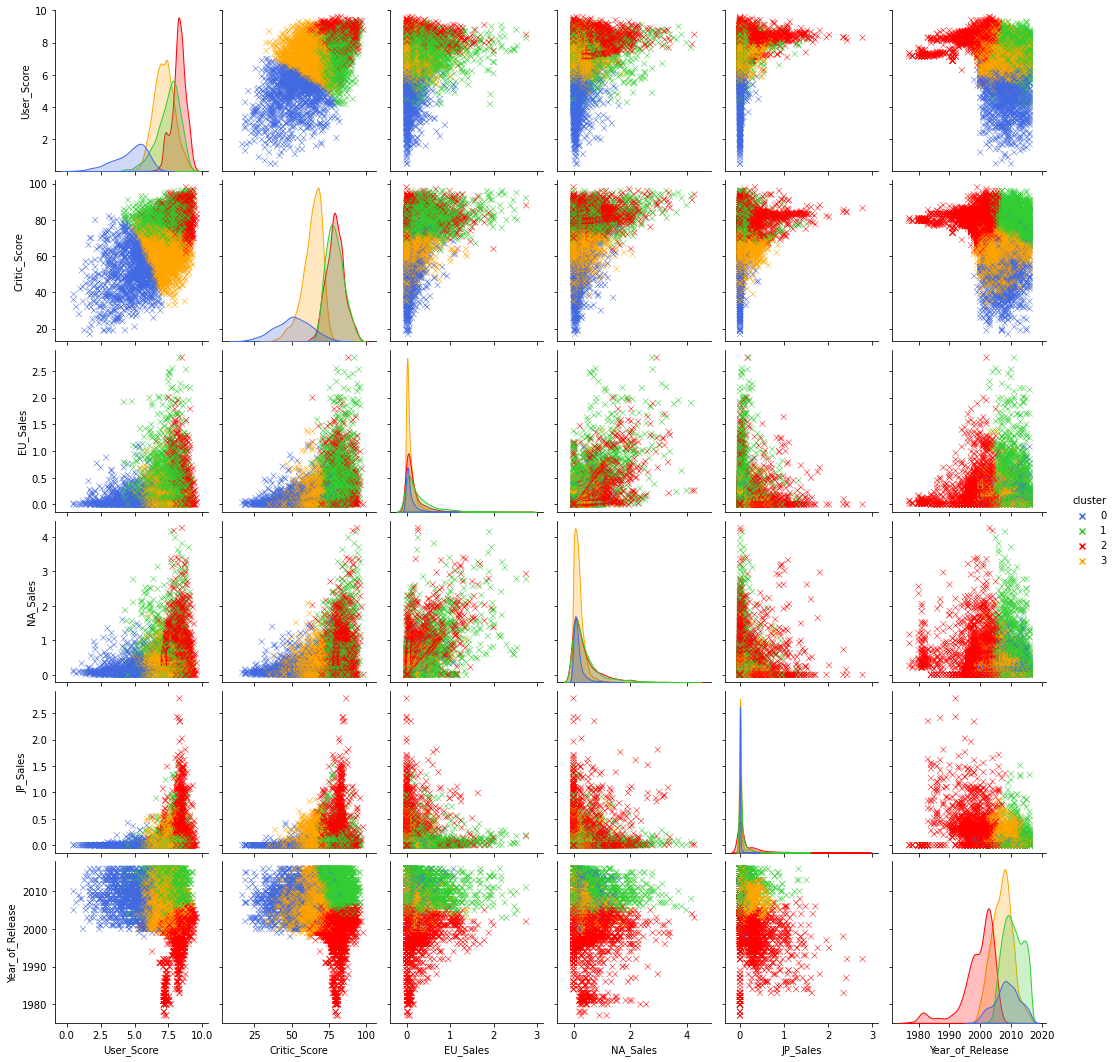

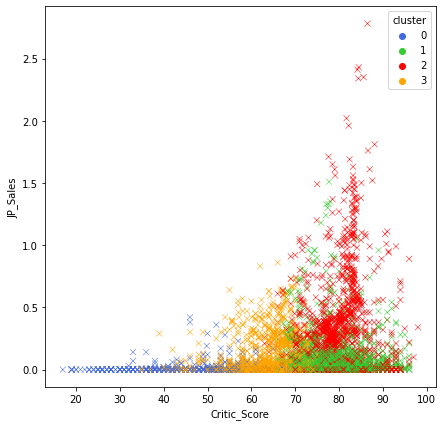

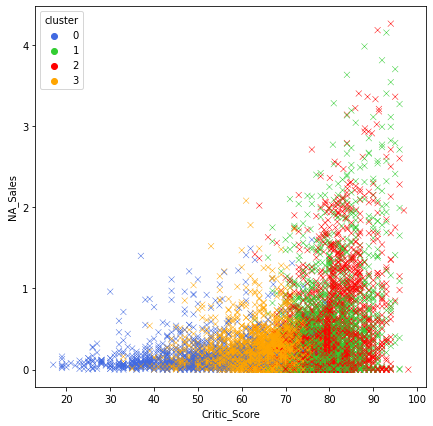

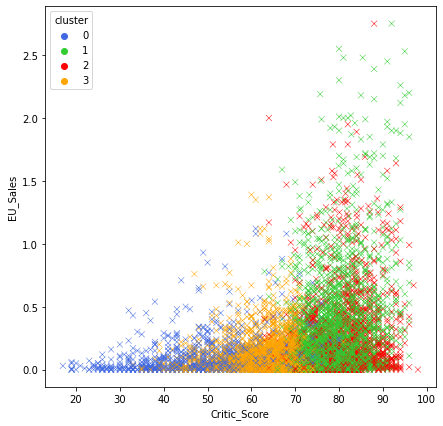

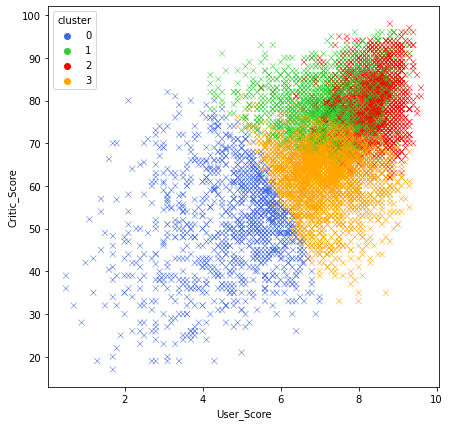

In [15]:
sns.pairplot(data=data, hue="cluster", markers=['x', 'x', 'x', 'x'], palette=palette)

plot_clusters_scatter(data, ("Critic_Score", "JP_Sales"), palette=palette)
plot_clusters_scatter(data, ("Critic_Score", "NA_Sales"), palette=palette)
plot_clusters_scatter(data, ("Critic_Score", "EU_Sales"), palette=palette)
plot_clusters_scatter(data, ("User_Score", "Critic_Score"), palette=palette)

### Clustering results visualisation using PCA

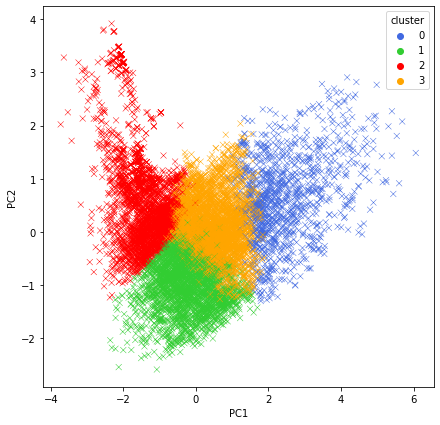

In [16]:
# standardize data
data[columns_used_for_clustering] = standardization.transform(data[columns_used_for_clustering])

# perform PCA
pca = PCA(n_components=2).fit(data.filter(columns_used_for_clustering))
reduced = pd.DataFrame(pca.transform(data.filter(columns_used_for_clustering)), columns=["PC1", "PC2"], index=data.index)
reduced.insert(2, "cluster", data["cluster"])

# visualize results after PCA
plot_clusters_scatter(reduced, ("PC1", "PC2"), palette=palette)

# reverse standardization
data[columns_used_for_clustering] = standardization.inverse_transform(data[columns_used_for_clustering])

### Clustering analysis - variable distribution for each cluster

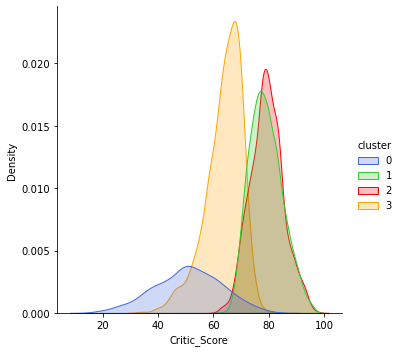

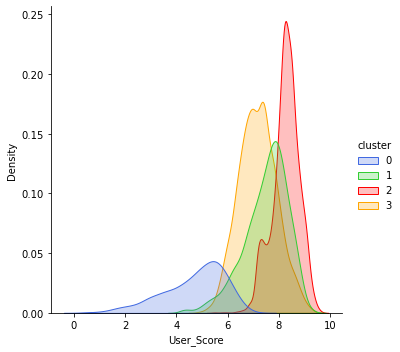

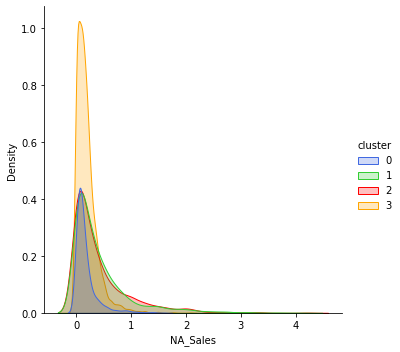

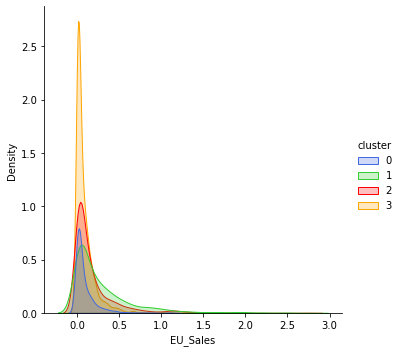

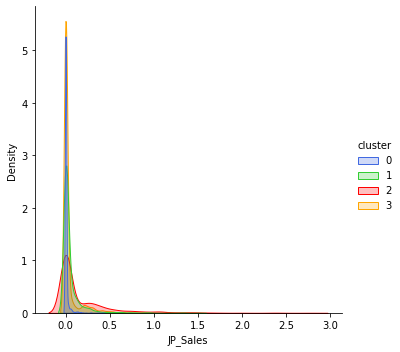

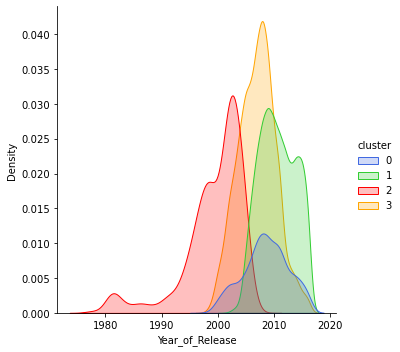

In [17]:
sns.displot(data, x="Critic_Score", hue="cluster", kind="kde", fill=True, palette=palette)
sns.displot(data, x="User_Score", hue="cluster", kind="kde", fill=True, palette=palette)
sns.displot(data, x="NA_Sales", hue="cluster", kind="kde", fill=True, palette=palette)
sns.displot(data, x="EU_Sales", hue="cluster", kind="kde", fill=True, palette=palette)
sns.displot(data, x="JP_Sales", hue="cluster", kind="kde", fill=True, palette=palette)
sns.displot(data, x="Year_of_Release", hue="cluster", kind="kde", fill=True, palette=palette)

### Clusters analysis - variables means for each cluster

         User_Score  Critic_Score  EU_Sales  NA_Sales  JP_Sales  \
cluster                                                           
0          4.699495     50.786858  0.084978  0.168999  0.006867   
1          7.487151     78.869442  0.285384  0.421256  0.053356   
2          8.242798     79.151068  0.175639  0.415675  0.165805   
3          7.158722     63.685368  0.082401  0.186869  0.036341   

         Year_of_Release  
cluster                   
0            2008.547433  
1            2010.612962  
2            1999.244662  
3            2006.980087  


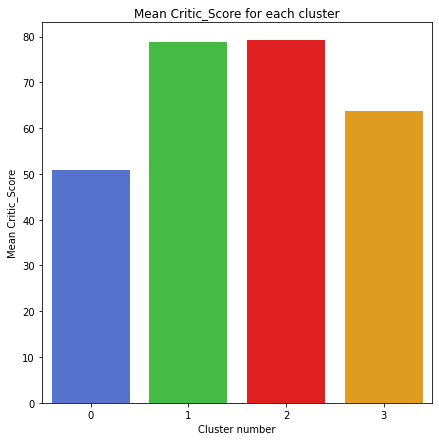

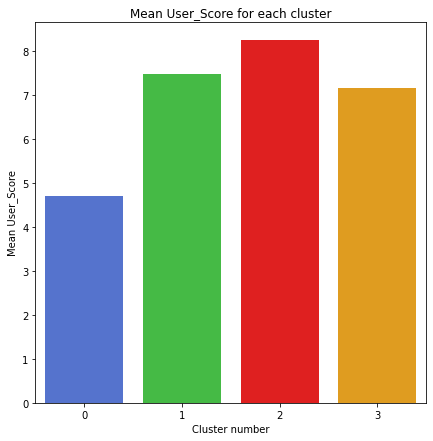

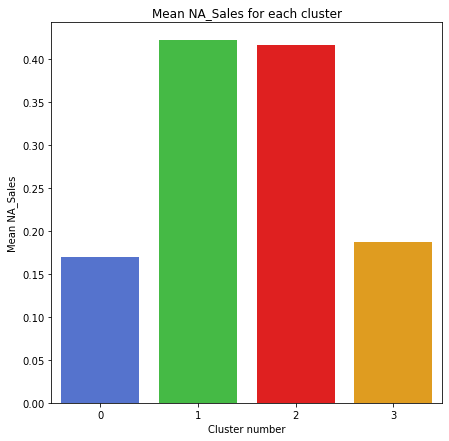

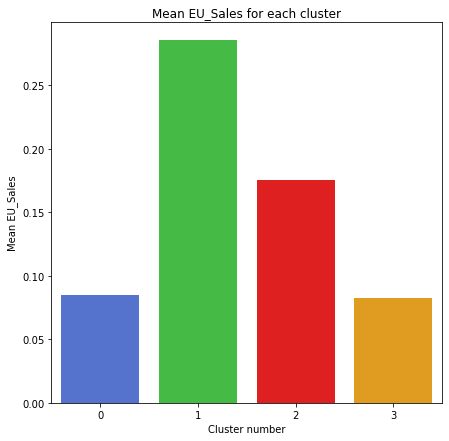

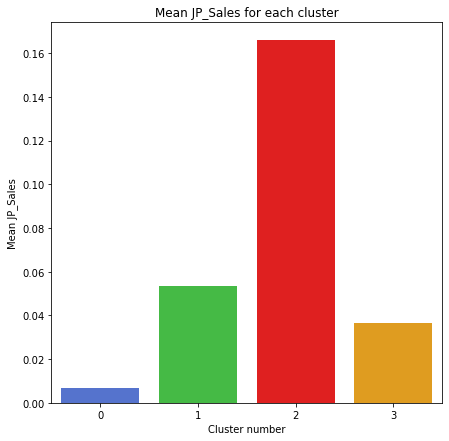

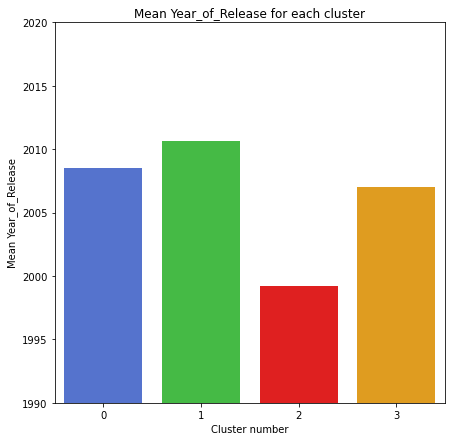

In [18]:
# print clusters means for each column
print(data.groupby("cluster").mean())

# display plots with means for each cluster
plot_means_in_clusters_for_given_column(data, "Critic_Score", colors=palette)
plot_means_in_clusters_for_given_column(data, "User_Score", colors=palette)
plot_means_in_clusters_for_given_column(data, "NA_Sales", colors=palette)
plot_means_in_clusters_for_given_column(data, "EU_Sales", colors=palette)
plot_means_in_clusters_for_given_column(data, "JP_Sales", colors=palette)
plot_means_in_clusters_for_given_column(data, "Year_of_Release", y_range=(1990, 2020), colors=palette)

### Clusters analysis - categorical variables

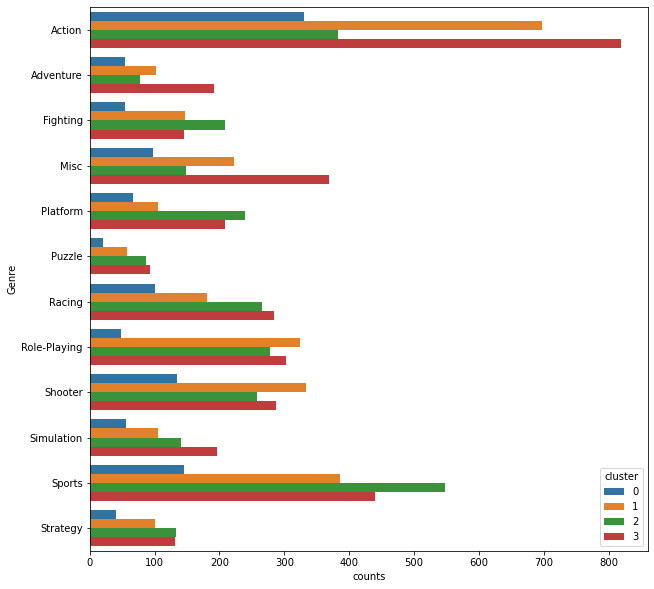

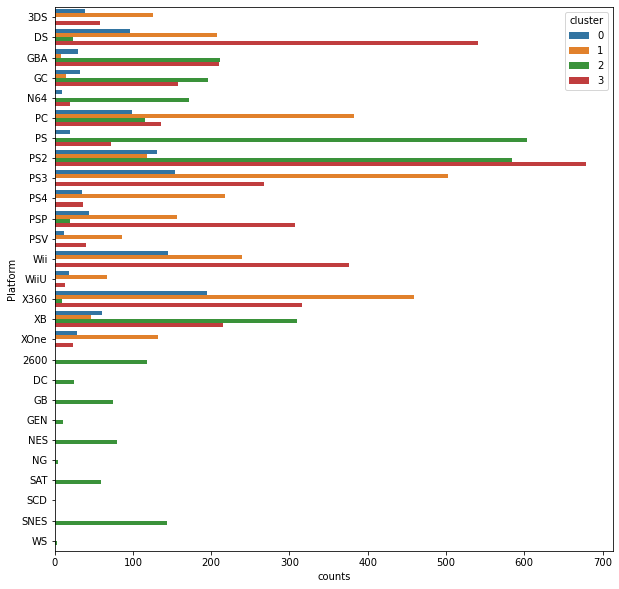

In [19]:
# genres
grouped_by_genre = data.groupby(["cluster", "Genre"]).size().reset_index(name='counts')
plt.figure(figsize=(10, 10))
sns.barplot(x="counts", y="Genre", hue="cluster", data=grouped_by_genre, orient='h')
plt.show()

# platforms
grouped_by_platform = data.groupby(["cluster", "Platform"]).size().reset_index(name='counts')
plt.figure(figsize=(10, 10))
sns.barplot(x="counts", y="Platform", hue="cluster", data=grouped_by_platform, orient='h')
plt.show()

### Classification to clusters
Here we compare results acquired using various classification method on a simple problem -
classification to clusters.

In [20]:
# prepare dataset
data[columns_used_for_clustering] = standardization.transform(data[columns_used_for_clustering])
data = data.drop(categorical_columns, axis=1)

# KNN classification
print("Performing KNN classification - leave one out method")
classification_score = k_neighbours_leave_one_out(data, "cluster", 3)
print("Score: {}".format(classification_score))

# Decision tree classification
print("Performing decision tree classification - leave one out method")
classification_score = decision_tree_leave_one_out(data, "cluster")
print("Score: {}".format(classification_score))


Performing KNN classification - leave one out method
Score: 0.9667620080875826
Performing decision tree classification - leave one out method
Score: 0.9616332971693461
